# Đồ án cuối kỳ môn khoa học dữ liệu CQ2016/2

## Đề tài: Phân loại danh mục của sản phẩm dựa trên tên sản phẩm

## <font color='blue'> Chi tiết quy trình thu thập dữ liệu, phân tích, huấn luyện dữ liệu để đưa ra model máy học dự đoán danh mục sản phẩm được chia làm những bước chính sau đây </font>

## Mục lục trình bày các bước:
* [B1: Thu thập dữ liệu  ](#first-bullet)
* [B2: Tiền xử lý dữ liệu](#second-bullet)
* [B3: Chuyển data dạng text sang vector](#second-bullet)
* [B4: Áp dụng các mô hình máy học khác nhau để huấn luyện dữ liệu, chọn ra mô hình tối ưu nhất](#second-bullet)

## Import các thư viện cần thiết

In [1]:
from requests_html import HTMLSession
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re  # For preprocessing
from IPython.display import display, HTML
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

## B1: Thu thập dữ liệu  <a class="anchor" id="first-bullet"></a>

Nhóm thực hiện thu thập dữ liệu trên trang [tiki.vn](https://tiki.vn/). Trước khi thu thập nhóm đã kiểm tra file `robot.txt` và thấy dữ liệu thu thập được hoàn toàn được trang tiki cho phép và hợp lệ

In [2]:
session = HTMLSession()
r = session.get('https://tiki.vn/')
r.encoding = 'utf-8'

data = []
link_category_dict = dict()

def parse_link(href, currentPage = 1):
    page = href+"&page="+str(currentPage)
    _session = HTMLSession()
    _r = _session.get(page)
    items = _r.html.find('.content .title')

    if len(items) == 0:
        return
    for item in items:
        category = link_category_dict[href]
        data.append([item.text.strip().rstrip("."), category])
    nextPage = currentPage+1
    try:
        print("page ", page)
        parse_link(href, nextPage)
    except Exception as e:
        print("some errors occured", str(e))

def get_categories():
    categories = []
    item_list = r.html.find('li.MenuItem-tii3xq-0 ')
    for item in item_list:
        href = item.find('a', first=True).attrs["href"]
        category = item.text
        categories.append((href, category))
        link_category_dict[href] = category
    return categories

def crawl_data():
    category_tuples = get_categories()
    for category_tuple in category_tuples:
        (href, category_name) = category_tuple
        # Không cần sleep vì tiki.vn đã có cơ chế rate limit request
        parse_link(href)

def save_data():
    np.random.shuffle(data)
    if len(data) != 0:
        with open('product.csv', 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(["product_title", "category"])
            for item in data:
                writer.writerow(item)

category_tuples = get_categories()
categorydf = pd.DataFrame(list(category_tuples), columns=['đường dẫn', 'tên danh mục'])
display(categorydf)
def run():
    print("start crawling")
    crawl_data()
    save_data()

# uncomment run() to start crawling data
# run()

,đường dẫn,tên danh mục
0,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,Điện Thoại - Máy Tính Bảng
1,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,Điện Tử - Điện Lạnh
2,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,Phụ Kiện - Thiết Bị Số
3,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,Laptop - Thiết bị IT
4,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,Máy Ảnh - Quay Phim
5,https://tiki.vn/dien-gia-dung/c1882?src=c.1882...,Điện Gia Dụng
6,https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...,Nhà Cửa Đời Sống
7,https://tiki.vn/bach-hoa-online/c4384?src=c.43...,Hàng Tiêu Dùng - Thực Phẩm
8,https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...,"Đồ chơi, Mẹ & Bé"
9,https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...,Làm Đẹp - Sức Khỏe


Sau khi thực hiện lấy danh sách các link danh mục sản phẩm như trên ta tiến hành thu thập dữ liệu đối với từng link. Crawler sẽ crawl hết tất cả các trang đối với từng danh mục bằng cách sử dungj param `page=` truyền vào request url sẽ có dạng như sau

https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner&_lc=Vk4wMzkwMTIwMDQ%3D?page=1

Sau khi crawl dữ liệu thành công ta đọc dữ liệu từ file `product.csv` và tạo data frame bằng pandas. Ta được mẫu dữ liệu như sau

In [3]:
df = pd.read_csv('product.csv')
print("count = ", df.count())
df.head(10)

count =  product_title    142291
category         142291
dtype: int64


,product_title,category
0,Giày Nam Thể Thao Tăng Chiều Cao 8cm Ohazo!,Thời trang - Phụ kiện
1,Bộ quần áo thun cotton 4 chiều cao cấp,"Đồ chơi, Mẹ & Bé"
2,Áo Khoác Ca Rô Cực Đẹp AK002,Thời trang - Phụ kiện
3,Bộ Thú Cưng Hoang Dã Của Bé Lego Duplo,"Đồ chơi, Mẹ & Bé"
4,Bộ Phát Wifi Di Động 3G Alcatel Y580 (21,Laptop - Thiết bị IT
5,3.5mm 1 to 2 Double Earphone Headphone Y,Hàng quốc tế
6,Folding Transparent 240 Holes Stud Earring,Hàng quốc tế
7,Ấm Đun Siêu Tốc AUX AK-15N01 (5L),Điện Gia Dụng
8,Phấn phủ bột khoáng kềm dầu LUA,Làm Đẹp - Sức Khỏe
9,Chai xịt sát trùng nhanh lành vết thương cho,Hàng Tiêu Dùng - Thực Phẩm


Tiến hành thống kê số lượng sản phẩm cho mỗi danh mục sau khi thu thập được

Text(0.5, 0, 'Số sản phẩm')

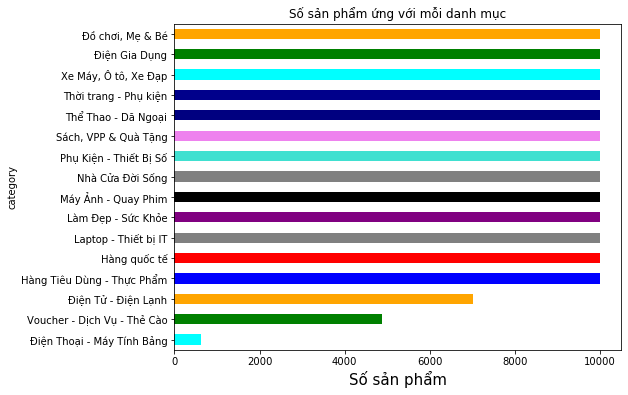

In [4]:
fig = plt.figure(figsize=(8,6))
colors = ['cyan','green','orange','blue','red','grey','purple','black','grey',
    'turquoise','violet','navy','darkblue']
df.groupby('category').product_title.count().sort_values().plot.barh(
    ylim=0, color=colors, title='Số sản phẩm ứng với mỗi danh mục')
plt.xlabel('Số sản phẩm', fontsize=15)

## B2: Tiền xử lý dữ liệu

Sau khi dữ liệu được thu thập, chúng ta cần xử lý dữ liệu để phục vụ việc training dữ liệu được tốt hơn
Chẳng hạn 1 dòng dữ liệu có `title` như sau

In [5]:
df.loc[142177]["product_title"]

'Combo 4 hộp Gà Hầm Vissan (150g)'

Ở ví dụ trên, ta thấy có những thông tin thừa thải không cần được đưa vào mô hình để huấn luyện như là các chữ `Combo`, `4`, `(150g)`. Vì vậy công việc tiền xử lý sẽ loại bỏ những thông tin này
Với ví dụ trên, ta mong muốn qua bước tiền xử lý. Thông tin còn lại sẽ là:

Combo 4 hộp Gà Hầm Vissan (150g) => <font color='red'>hộp Gà Hầm Vissan</font>

### Lấy danh sách các stop word

In [6]:
stop_words = list(line.strip() for line in open('stopword.txt'))
print(stop_words)

['cho', 'các', 'còn', 'có', 'cũng', 'của', 'hai', 'hoa', 'họ', 'dành', 'khi', 'tham', 'không', 'liên', 'kết', 'loài', 'là', 'làm', 'miêu', 'một', 'ngoài', 'ngày', 'người', 'nhiều', 'như', 'nhất', 'những', 'này', 'nó', 'năm', 'ra', 'sau', 'theo', 'thuộc', 'tháng', 'thêm', 'trong', 'trên', 'tên', 'tại', 'tỉnh', 'từ', 'và', 'vào', 'về', 'với', 'xem', 'xinh', 'xắn', 'đã', 'đó', 'được', 'đến', 'để', 'combo', 'hãng']


Tạo class `TextPreprocessor` implement interface `transformer` của Sklearn. TextPreprocessor sẽ làm nhiệm vụ lowercase, xoá các stopword, số, các kí tự đặc biệt, dấu chấm câu khỏi product_title

In [7]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words = []):
        self.stop_words = stop_words
    def fit(self, X_df, y=None):
        categories = X_df['category'].unique()
        # Thêm cột category_id, map category thành số 
        self.category_to_id = {}
        assign_id = 0
        for category in categories:
            self.category_to_id[category] = assign_id
            assign_id += 1  # Get a new id for new author
        # Dict lưu key: id, value: tên category    
        self.id_to_category = {v: k for k, v in self.category_to_id.items()}
        
    def id_to_categoryname(self, category_id):
        return self.id_to_category[category_id]
    
    def get_category_id(self, category):
        return self.category_to_id[category]
    
    def cleanText(self, text): 
        # Convert text to lower
        text = text.lower()
        # Removing non alphabetic words
        # word contains number | hyphen | paranthesis
        text = re.sub(r'\S*\d\S*|-|\(.*\)', r'', text)

        # Removing all the stopwords
        filtered_words = [word for word in text.split() if word not in stop_words]
        text = " ".join(filtered_words)

        # strip multiple spaces
        text = re.sub(' +', ' ', text)

        # strip punctuation
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def transform(self, X_df, y=None):
        new_X_df = X_df.copy()
        new_X_df['category_id'] = new_X_df['category'].map(self.get_category_id)
        new_X_df.drop(['category'], axis=1)
        new_X_df["product_title"] = new_X_df["product_title"].map(self.cleanText)        
        return new_X_df
    

    


### Dữ liệu trước khi tiền xử lý

In [8]:
df.head(10)

,product_title,category
0,Giày Nam Thể Thao Tăng Chiều Cao 8cm Ohazo!,Thời trang - Phụ kiện
1,Bộ quần áo thun cotton 4 chiều cao cấp,"Đồ chơi, Mẹ & Bé"
2,Áo Khoác Ca Rô Cực Đẹp AK002,Thời trang - Phụ kiện
3,Bộ Thú Cưng Hoang Dã Của Bé Lego Duplo,"Đồ chơi, Mẹ & Bé"
4,Bộ Phát Wifi Di Động 3G Alcatel Y580 (21,Laptop - Thiết bị IT
5,3.5mm 1 to 2 Double Earphone Headphone Y,Hàng quốc tế
6,Folding Transparent 240 Holes Stud Earring,Hàng quốc tế
7,Ấm Đun Siêu Tốc AUX AK-15N01 (5L),Điện Gia Dụng
8,Phấn phủ bột khoáng kềm dầu LUA,Làm Đẹp - Sức Khỏe
9,Chai xịt sát trùng nhanh lành vết thương cho,Hàng Tiêu Dùng - Thực Phẩm


### Dữ liệu sau tiền xử lý

In [9]:
textProcessor = TextPreprocessor(stop_words)
textProcessor.fit(df)
transformed_df = textProcessor.transform(df)
transformed_df.head(10)

,product_title,category,category_id
0,giày nam thể thao tăng chiều cao ohazo,Thời trang - Phụ kiện,0
1,bộ quần áo thun cotton chiều cao cấp,"Đồ chơi, Mẹ & Bé",1
2,áo khoác ca rô cực đẹp,Thời trang - Phụ kiện,0
3,bộ thú cưng hoang dã bé lego duplo,"Đồ chơi, Mẹ & Bé",1
4,bộ phát wifi di động alcatel,Laptop - Thiết bị IT,2
5,to double earphone headphone y,Hàng quốc tế,3
6,folding transparent holes stud earring,Hàng quốc tế,3
7,ấm đun siêu tốc aux,Điện Gia Dụng,4
8,phấn phủ bột khoáng kềm dầu lua,Làm Đẹp - Sức Khỏe,5
9,chai xịt sát trùng nhanh lành vết thương,Hàng Tiêu Dùng - Thực Phẩm,6


In [10]:
transformed_df.loc[142177]["product_title"]

'hộp gà hầm vissan'

vậy là từ `Combo 4 hộp Gà Hầm Vissan (150g)`, dữ liệu đã được tiền xử lý và trở thành `hộp gà hầm vissan`

## Bước 3: Chuyển data dạng text sang vector

### Tách tập huấn huấn luyện, tập test từ data được tiền xử lý

In [11]:
# Tách tập (train + validation) và tập test theo tỉ lệ 70%:30%

X_trainVal, X_test, y_trainVal, y_test = train_test_split(
    transformed_df['product_title'], transformed_df['category_id'], test_size=0.33, random_state=42)

# tách tập thành tập train và validation từ tập trainVal
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.33, random_state=1)

### Chuyển data text sang vector số

In [21]:
count_vect = CountVectorizer(analyzer= "word", stop_words=stop_words)
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  (0, 18327)	0.2515241603572169
  (0, 18295)	0.27243971232010433
  (0, 17493)	0.33741290275111685
  (0, 15902)	0.4968485195264628
  (0, 6919)	0.22054781471736556
  (0, 6909)	0.2781323525836064
  (0, 3522)	0.22424299282766794
  (0, 3423)	0.2804709722782714
  (0, 1792)	0.4968485195264628
  (1, 17433)	0.2147581132015833
  (1, 17028)	0.30462931542423805
  (1, 16158)	0.25248142612573676
  (1, 12544)	0.3386262612279149
  (1, 11985)	0.3686976083787385
  (1, 11957)	0.3763495741520684
  (1, 2704)	0.4162179692342625
  (1, 2695)	0.22958723682012896
  (1, 1895)	0.4232501530463207
  (2, 18237)	0.3084270665030953
  (2, 10205)	0.3568365857132333
  (2, 10120)	0.29243118464984524
  (2, 8192)	0.30029621134939505
  (2, 6490)	0.3749480131970747
  (2, 1899)	0.31834747920696
  (2, 1516)	0.5999295402965633
  :	:
  (63869, 1963)	0.19264719867163857
  (63870, 17433)	0.2054904510428549
  (63870, 15759)	0.543925886009067
  (63870, 15462)	0.2533859700405693
  (63870, 14810)	0.390765735508586
  (63870, 14057)	0.50

### Transform dữ liệu text của tập validation sang vector từ model đã thu được trươc đó


In [13]:
X_val_counts = count_vect.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

# B4: Dùng các model máy học khác nhau để dự đoán

## Tạo model dự đoán naive bayes

In [14]:
mnb_clf = MultinomialNB().fit(X_train_tfidf, y_train)

## Dùng model dự đoán tập validation

In [15]:
multinomialNB_predict = mnb_clf.predict(X_val_tfidf)
multinomialNB_score = accuracy_score(y_val, multinomialNB_predict) * 100
print("Naive bayes Accuracy Score -> ", multinomialNB_score)

Naive bayes Accuracy Score ->  80.60455802422047


## Dùng model Linear support vector machine (SGD)

In [16]:
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, y_train)

# predict the labels on validation dataset
sdg_predict = sgd_clf.predict(X_val_tfidf)
sgd_score = accuracy_score(y_val, sdg_predict) * 100
print("SGD Accuracy Score -> ", sgd_score)

SGD Accuracy Score ->  74.83233209370331


## Dùng model Logistic Regression

In [17]:
lgt_clf = LogisticRegression(n_jobs=1, C=1e5, max_iter=100, solver='lbfgs', multi_class='auto').fit(X_train_tfidf, y_train)
predictions_LGT = lgt_clf.predict(X_val_tfidf)
lgt_score = accuracy_score(y_val, predictions_LGT) * 100
print("LGT Accuracy Score -> ", lgt_score )

LGT Accuracy Score ->  83.64006229935475


/usr/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:946: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


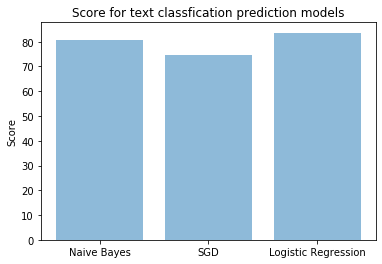

In [18]:
objects = ('Naive Bayes', 'SGD', 'Logistic Regression')
y_pos = np.arange(len(objects))
scores = [multinomialNB_score,sgd_score, lgt_score]

plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Score for text classfication prediction models')

plt.show()

Sau khi chạy xong 3 mô hình máy học khác nhau thì ta thấy mô hình logistic regression có kết quả tốt nhất.

Ta dùng model logistic regression để thực hiện train trên tập dữ liệu gồm có tập train và tập validation để tối ưu hóa kết quả

In [19]:
# X_trainVal là tập dữ liệu gồm tạp train và validation
X_counts = count_vect.transform(X_trainVal)
X_tfidf = tfidf_transformer.transform(X_counts)

lr = LogisticRegression(n_jobs=1, C=1e5, max_iter=100, solver='lbfgs', multi_class='auto')
last_lr_clf = lr.fit(X_tfidf, y_trainVal)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


last_lr_predict = last_lr_clf.predict(X_test_tfidf)
last_lr_test_score = accuracy_score(y_test, last_lr_predict) * 100
print("Naive bayes test Accuracy Score -> ", last_lr_test_score)

/usr/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:946: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


Naive bayes test Accuracy Score ->  85.01181932406244


Sau khi dự đoán với tập test ta thu được score: 85.01

## Dự đoán với dữ liệu bất kì

In [20]:
X_input = ["Bàn phím acer", "lược sử loài người", "Trái đất hình thành như thế nào?",
             "Như là giấc mơ", "Găng tay xe đạp", "Bình nước nóng sanyo"]
X_input_counts = count_vect.transform(X_input)
X_input_tfidf = tfidf_transformer.transform(X_input_counts)
x_input_predict= last_lr_clf.predict(X_input_tfidf)
counter = 0
for doc, category_id in zip(X_input, x_input_predict):
    print('%r => %s' % (doc, textProcessor.id_to_categoryname(category_id)))
    if(counter == 10):
        break
    counter += 1

'Bàn phím acer' => Laptop - Thiết bị IT
'lược sử loài người' => Sách, VPP & Quà Tặng
'Trái đất hình thành như thế nào?' => Sách, VPP & Quà Tặng
'Như là giấc mơ' => Sách, VPP & Quà Tặng
'Găng tay xe đạp' => Xe Máy, Ô tô, Xe Đạp
'Bình nước nóng sanyo' => Điện Gia Dụng
